In [47]:
from IPython.display import clear_output  # clear_output(wait=True)
import os
import re
from os.path import isfile, join

import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy import spatial
from skimage import morphology
from tqdm import tqdm

In [82]:
video = 'pexels_5'  # bridge, highway, night, highway_day, highway_night, cars_640, back_view_640, night_speed_640, pexels_2, pexels_4, pexels_5
video_mp4 = video + '.mp4'
video_dir = video + '/'

in_dir = '../videos/'
out_dir = '../out_videos/frame_diff/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

video_in_path = os.path.join(in_dir, video_mp4)
video_out_path = os.path.join(out_dir, video_mp4)

video_frames_dir = 'processing/frames/'
video_frames_path = os.path.join(video_frames_dir, video_dir)
if not os.path.exists(video_frames_path):
    os.makedirs(video_frames_path)

video_contours_dir = 'processing/contour_frames/'
video_contours_path = os.path.join(video_contours_dir, video_dir)
if not os.path.exists(video_contours_path):
    os.makedirs(video_contours_path)

In [83]:
# CAP_PROP_POS_MSEC      Current position of the video file in milliseconds or video capture timestamp.
# CAP_PROP_POS_FRAMES    0-based index of the frame to be decoded/captured next.
# CAP_PROP_POS_AVI_RATIO Relative position of the video file: 0 - start of the film, 1 - end of the film.
# CAP_PROP_FRAME_WIDTH   Width of the frames in the video stream.
# CAP_PROP_FRAME_HEIGHT  Height of the frames in the video stream.
# CAP_PROP_FPS           Frame rate.
# CAP_PROP_FOURCC        4-character code of codec.
# CAP_PROP_FRAME_COUNT   Number of frames in the video file.
# CAP_PROP_FORMAT        Format of the Mat objects returned by retrieve() .
# CAP_PROP_MODE          Backend-specific value indicating the current capture mode.
# CAP_PROP_BRIGHTNESS    Brightness of the image (only for cameras).
# CAP_PROP_CONTRAST      Contrast of the image (only for cameras).
# CAP_PROP_SATURATION    Saturation of the image (only for cameras).
# CAP_PROP_HUE           Hue of the image (only for cameras).
# CAP_PROP_GAIN          Gain of the image (only for cameras).
# CAP_PROP_EXPOSURE      Exposure (only for cameras).
# CAP_PROP_CONVERT_RGB   Boolean flags indicating whether images should be converted to RGB.
# CAP_PROP_WHITE_BALANCE Currently not supported
# CAP_PROP_RECTIFICATION Rectification flag for stereo cameras (note: only supported by DC1394 v 2.x backend currently)


def vidcap_describe(vidcap):
    print(f'Width: \t\t{round(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))}')
    print(f'Height: \t{round(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))}')
    print(f'FPS: \t\t{round(vidcap.get(cv2.CAP_PROP_FPS))}')
    print(f'Frames count:\t{round(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))}')

In [84]:
# Initialize the video stream, pointer to output video file
vidcap = cv2.VideoCapture(video_in_path)
vidcap_describe(vidcap)

video_width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_fps = int(vidcap.get(cv2.CAP_PROP_FPS))
video_frames_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

Width: 		1280
Height: 	720
FPS: 		24
Frames count:	544


In [88]:
DETECTION_ZONE_PERCENTAGE = 0.8 # default 0.4; 0.8 for pexel_5; 0.25 for pexel_4; 0.5 for hoghway_2
THRESHHOLD = 30
# dilatation
KERNEL_SIZE = 3
DILATE_ITER = 5

COUNTOUR_AREA = 8000 # 1000 for pexel_5; 1000 for pexel_4

In [90]:
FRAMES_BEFORE_CURRENT = round(video_fps / 5)    # (e.g. 60/4 = 15)

detection_zone_x1 = 0
detection_zone_y1 = int(video_height * (1-DETECTION_ZONE_PERCENTAGE))
detection_zone_x2 = video_width
detection_zone_y2 = video_height

DETECTION_ZONE = [
    (detection_zone_x1, detection_zone_y1),
    (detection_zone_x2, detection_zone_y2)
]

In [91]:
DETECTION_ZONE

[(0, 143), (1280, 720)]

## Ekstrakcja i zapis klatek wejściowego strumienia wideo

In [92]:
success, image = vidcap.read()

count = 0
while success:
    # save frame as PNG file
    cv2.imwrite('%s%d.png' % (video_frames_path, count), image)
    success, image = vidcap.read()

    clear_output(wait=True)
    print(f'Read {count} frame: {success}')

    count += 1

Read 543 frame: False


## Wczytanie klatek do pamięci

In [93]:
# get file names of the frames
col_frames = os.listdir(video_frames_path)

# sort file names
col_frames.sort(key=lambda f: int(re.sub('\D', '', f)))

# list to store the frames
col_images = []
for i in tqdm(col_frames):
    # read the frames
    img = cv2.imread(video_frames_path + i)
    # append the frames to the list
    col_images.append(img)

100%|██████████| 544/544 [00:10<00:00, 52.64it/s]


## Odnalezienie 2 kolejnych klatek do eksploracji

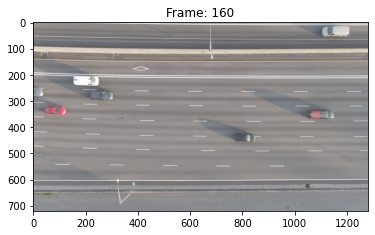

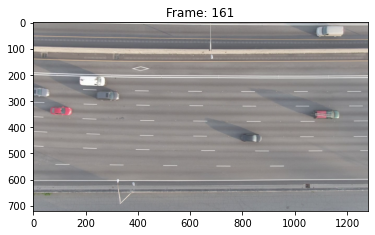

In [94]:
# plot i and i+1 frame
fr = 160  # 15, 325, 100 - cars_640, 125 - back_view_640
for frame in [fr, fr+1]:
    plt.imshow(cv2.cvtColor(col_images[frame], cv2.COLOR_BGR2RGB))
    plt.title(f'Frame: {str(frame)}')
    plt.show()

## Konwersja klatek do skali szarości oraz różnicowanie klatek

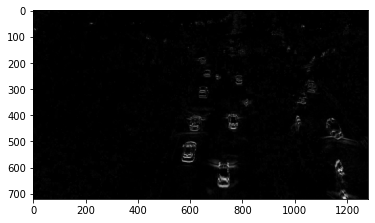

In [57]:
# convert the frames to grayscale
grayA = cv2.cvtColor(col_images[fr], cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(col_images[fr+1], cv2.COLOR_BGR2GRAY)

# plot the image after frame differencing
plt.imshow(cv2.absdiff(grayB, grayA), cmap='gray')
plt.show()

## Binaryzacja różnicowanych klatek - progowanie

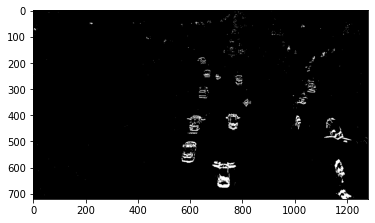

In [71]:
if video == 'highway':
    THRESHHOLD = 30
elif video == 'night':
    THRESHHOLD = 80
elif video == 'bridge':
    THRESHHOLD = 30
elif video == 'highway_day':
    THRESHHOLD = 75
elif video == 'cars_640':
    THRESHHOLD = 30  # 35
elif video == 'back_view_640':
    THRESHHOLD = 30  # 20, ad: 11, -20
elif video == 'night_speed_640':
    THRESHHOLD = 80
elif video == 'pexels_1':
    THRESHHOLD = 20
elif video == 'pexels_2':
    THRESHHOLD = 30
elif video == 'pexels_5':
    THRESHHOLD = 30 # 40
elif video == 'night_2':
    THRESHHOLD = 40 # 40

diff_image = cv2.absdiff(grayB, grayA)

# perform image thresholding
thresh = cv2.threshold(diff_image, THRESHHOLD, 255, cv2.THRESH_BINARY)[1]
# thresh = cv2.adaptiveThreshold(diff_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 17, -20) 
# thresh = cv2.adaptiveThreshold(diff_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 17, -20)

# plot image after thresholding
plt.imshow(thresh, cmap='gray')
plt.show()

In [72]:
# plt.imshow(cv2.GaussianBlur(diff_image, (5,5), 10), cmap='gray')
# plt.show()

In [73]:
# kernel_a = np.ones((5, 5), np.uint8)
# opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_a)
# cleaned = morphology.remove_small_objects(opening, min_size=80, connectivity=2)

# # plt.imshow(cleaned, cmap='gray')}
# # plt.show()
# cv2.imshow("cleaned", cleaned)

## Dylatacja różnicowanych klatek

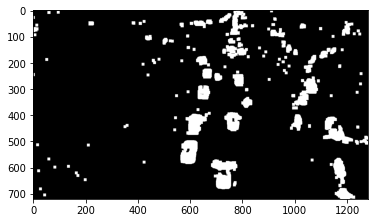

In [74]:
if video == 'highway':
    KERNEL_SIZE = 3
    DILATE_ITER = 1
elif video == 'night':
    KERNEL_SIZE = 31
    DILATE_ITER = 1
elif video == 'bridge':
    KERNEL_SIZE = 3
    DILATE_ITER = 1
elif video == 'highway_day':
    KERNEL_SIZE = 50
    DILATE_ITER = 1
elif video == 'cars_640':
    KERNEL_SIZE = 5 # 15 i:1 - better for stadard threshhold
    DILATE_ITER = 5
elif video == 'back_view_640':
    KERNEL_SIZE = 3 # 7, 9 - better for stadard threshhold, 13 - ok for ADAPTIVE_THRESH_MEAN_C
    DILATE_ITER = 5
elif video == 'night_speed_640':
    KERNEL_SIZE = 9 # 7
    DILATE_ITER = 1
elif video == 'pexels_1':
    KERNEL_SIZE = 3
    DILATE_ITER = 5
elif video == 'pexels_2':
    KERNEL_SIZE = 3
    DILATE_ITER = 5
elif video == 'pexels_3':
    KERNEL_SIZE = 3
    DILATE_ITER = 5
elif video == 'pexels_4':
    KERNEL_SIZE = 3
    DILATE_ITER = 5
elif video == 'pexels_5':
    KERNEL_SIZE = 3
    DILATE_ITER = 5

# apply image dilation
kernel = np.ones((KERNEL_SIZE,KERNEL_SIZE), np.uint8)
dilated = cv2.dilate(thresh, kernel, iterations=DILATE_ITER)

# plot dilated image
plt.imshow(dilated, cmap='gray')
plt.show()

## Ustalenie strefy detekcji

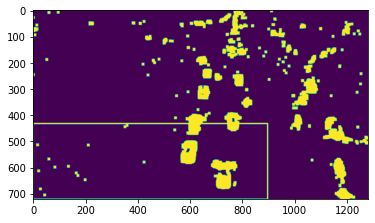

In [75]:
# if video == 'highway':
#     DETECTION_ZONE = [(0,80), (256,80)]
# elif video == 'night':
#     DETECTION_ZONE = [(0,500), (1280,500)]
# elif video == 'bridge':
#     DETECTION_ZONE = [(0,80), (256,80)]
# elif video == 'highway_day':
#     DETECTION_ZONE = [(0,600), (1376,600)]
# elif video == 'cars_640':
#     DETECTION_ZONE = [(160,200), (640,200)]
# elif video == 'back_view_640':
#     DETECTION_ZONE = [(0,240), (500,240)]
# elif video == 'back_view_640':
#     DETECTION_ZONE = [(0,240), (500,240)]
# elif video == 'pexels_1':
#     DETECTION_ZONE = [(0,240), (500,240)]
# elif video == 'pexels_2':
#     DETECTION_ZONE = [(0,400), (1280,400)]

# plot vehicle detection zone
# cv2.line(dilated, DETECTION_ZONE[0], DETECTION_ZONE[1], (255,1,1), 5)     # dilatation_line misssing
cv2.rectangle(dilated, DETECTION_ZONE[0], DETECTION_ZONE[1], (255,1,1), 3)

plt.imshow(dilated)
plt.show()

## Odnajdywanie konturów obiektów znajdujących się w polu detekcji

In [76]:
# find contours
# contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
contours, hierarchy = cv2.findContours(dilated.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [77]:
len(contours)

124

In [78]:
valid_cntrs = []
valid_bboxes = [[], []]

for cntr in contours:
    x, y, w, h = cv2.boundingRect(cntr)
    x1, x2 = x, x+w
    y1, y2 = y, y+h
    center_x, center_y = int(x+(w/2)), int(y+(h/2))

    cntr_rect = np.asarray([
        [[x1, y1]], 
        [[x2, y1]],
        [[x2, y2]],
        [[x1, y2]]
    ])

    if (x >= DETECTION_ZONE[0][0]) and \
       (x <= DETECTION_ZONE[1][0]) and \
       (y >= DETECTION_ZONE[0][1]) and \
       (y <= DETECTION_ZONE[1][1]) and \
       (cv2.contourArea(cntr_rect) >= 500):    # COUNTOUR_AREA
        valid_bboxes[0].append(
            cntr_rect
        )
        valid_bboxes[1].append(
            [x, y, w, h, center_x, center_y]
        )

len(valid_bboxes)

2

In [79]:
# valid_cntrs = []
# valid_bboxes = [[], []]

# for cntr in contours:
#     x, y, w, h = cv2.boundingRect(cntr)
#     x1, x2 = x, x+w
#     y1, y2 = y, y+h
#     center_x, center_y = int(x+(w/2)), int(y+(h/2))

#     if video == 'highway':
#         if (x <= 220) & (y >= 80) & (cv2.contourArea(cntr) >= 25):
#             valid_cntrs.append(cntr)
#             valid_bboxes[0].append(
#                 np.asarray([
#                     [[x1, y1]], 
#                     [[x2, y1]],
#                     [[x2, y2]],
#                     [[x1, y2]]
#                 ])
#             )
#             valid_bboxes[1].append(
#                 [x, y, w, h, center_x, center_y]
#             )
#     elif video == 'night':
#         if (x >= 600) & (y >= 500) & (cv2.contourArea(cntr) >= 25):
#             valid_cntrs.append(cntr)
#             valid_bboxes[0].append(
#                 np.asarray([
#                     [[x, y]], 
#                     [[x+w, y]],
#                     [[x+w, y+h]],
#                     [[x, y+h]]
#                 ])
#             )
#             valid_bboxes[1].append(
#                 [x, y, w, h, center_x, center_y]
#             )
#     elif video == 'bridge':
#         if (x <= 200) & (y >= 80) & (cv2.contourArea(cntr) >= 25):
#             valid_cntrs.append(cntr)
#             valid_bboxes[0].append(
#                 np.asarray([
#                     [[x, y]], 
#                     [[x+w, y]],
#                     [[x+w, y+h]],
#                     [[x, y+h]]
#                 ])
#             )
#     elif video == 'highway_day':
#         if (y >= 600) & (cv2.contourArea(cntr) >= 500):
#             valid_cntrs.append(cntr)
#             valid_bboxes[0].append(
#                 np.asarray([
#                     [[x, y]], 
#                     [[x+w, y]],
#                     [[x+w, y+h]],
#                     [[x, y+h]]
#                 ])
#             )
#             valid_bboxes[1].append(
#                 [x, y, w, h, center_x, center_y]
#             )
#     elif video == 'cars_640':
#         if (x >= 160) & (y >= 200) & (cv2.contourArea(cntr) >= 2800):
#             valid_cntrs.append(cntr)
#             valid_bboxes[0].append(
#                 np.asarray([
#                     [[x, y]], 
#                     [[x+w, y]],
#                     [[x+w, y+h]],
#                     [[x, y+h]]
#                 ])
#             )
#     elif video == 'back_view_640':
#         if (x <= 500) & (y >= 240) & (cv2.contourArea(cntr) >= 1000):
#             valid_cntrs.append(cntr)
#             valid_bboxes[0].append(
#                 np.asarray([
#                     [[x, y]], 
#                     [[x+w, y]],
#                     [[x+w, y+h]],
#                     [[x, y+h]]
#                 ])
#             )
#             valid_bboxes[1].append(
#                 [x, y, w, h, center_x, center_y]
#             )
#     elif video == 'pexels_2':
#         if (x <= 1000) & (y >= 400) & (cv2.contourArea(cntr) >= 6000):
#             valid_cntrs.append(cntr)
#             valid_bboxes[0].append(
#                 np.asarray([
#                     [[x, y]], 
#                     [[x+w, y]],
#                     [[x+w, y+h]],
#                     [[x, y+h]]
#                 ])
#             )
#             valid_bboxes[1].append(
#                 [x, y, w, h, center_x, center_y]
#             )


# # count of discovered contours        
# len(valid_cntrs)

In [80]:
# test_cntr = np.asarray([
#     [[273, 288]], 
#     [[333, 288]],
#     [[333, 360]],
#     [[273, 360]]
# ])

# test_cntr = [test_cntr]

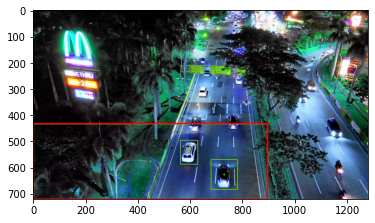

In [81]:
dmy = col_images[fr].copy()

# cv2.drawContours(dmy, valid_cntrs, -1, (127,200,0), 2)
cv2.drawContours(dmy, valid_bboxes[0], -1, (127,200,0), 2)
# cv2.line(dmy, DETECTION_LINE[0], DETECTION_LINE[1], (0,255,0), 5)
cv2.rectangle(dmy, DETECTION_ZONE[0], DETECTION_ZONE[1], (255,1,1), 3)

# Draw a green dot in the middle of the box
for center_point in valid_bboxes[1]:
    cv2.circle(
        dmy, 
        (center_point[4], center_point[5]), 
        2, 
        (0, 0xFF, 0), 
        2
    )

plt.imshow(dmy)
plt.show()

## Wykonanie powyższych proków na całym zbiorze klatek + zliczanie obiektów

In [235]:
# PURPOSE: Draw detection zone 
# PARAMETERS: 
#   - detection_zone - detection zone placement
#   - frame - frame on which the detection zone is displayed
def draw_detection_zone(detection_zone, frame):
    cv2.rectangle(
        frame, 
        detection_zone[0],
        detection_zone[1], 
        (255,1,1), 
        3
    )
    # cv2.line(
    #     frame, 
    #     detection_zone[0],
    #     detection_zone[1], 
    #     (255,1,1), 
    #     5
    # )

In [236]:
# PURPOSE: Display the vehicle count on the top-left corner of the frame
# PARAMETERS: 
#   - frame - frame on which the count is displayed
#   - vehicle_count - number of vehicles
def display_vehicle_count(vehicle_count, frame):
    cv2.putText(
        frame,
        'Detected Vehicles: ' + str(vehicle_count), 
        (20, 45), 
        cv2.FONT_HERSHEY_SIMPLEX, 
        0.8, 
        (0, 0xFF, 0), 
        2
    )

In [237]:
# PURPOSE: Draw detection box id on its center
# PARAMETERS: 
#   - current_box_id - current box id
#   - current box center - current box center
#   - frame - frame on which the detection boxes are displayed
def draw_detection_box_id(current_box_id, current_box_center, frame):
    cv2.putText(
        frame, 
        current_box_id, 
        current_box_center, 
        cv2.FONT_HERSHEY_SIMPLEX, 
        0.5, 
        [0, 0, 255], 
        2
    )

In [238]:
# PURPOSE: Identifying if the current box was present in the previous frames
# PARAMETERS: 
#   - prev_frames_detections - all the vehicular detections of N previous frames (N = FRAMES_BEFORE_CURRENT)
#   - current_box - current box
#   - current_detections - the coordinates of the box of previous detections
# RETURN: 
#   - False - if the box was present in previous frames
#	- True - if the box wasn't present in previous frames (is new)
def is_new_object(prev_frames_detections, current_box, current_detections):
    center_x, center_y, width, height = current_box

    dist = np.inf
    # Iterating through all the k-dimensional trees
    for i in range(FRAMES_BEFORE_CURRENT):
        prev_frame_detections = list(prev_frames_detections[i].keys())
        if len(prev_frame_detections) == 0:
            continue
        # Finding the distance to the closest point and the index
        temp_dist, index = spatial.KDTree(prev_frame_detections).query([(center_x, center_y)])
        if temp_dist < dist:
            dist = temp_dist
            frame_num = i
            coords = prev_frame_detections[index[0]]

    if dist > (max(width, height) / 2):
        return True

    # Keeping the vehicle ID constant
    current_detections[(center_x, center_y)] = prev_frames_detections[frame_num][coords]

    return False

In [239]:
# PURPOSE: Get current vehicle count + valid detections
# PARAMETERS:
#   - boxes - all bounding boxes info in detection zone (e.g. [top_left_x, top_left_y, width, height, center_x, center_y])
#   - vehicle_count - current vehicle count
#   - prev_frames_detections - all the vehicular detections of N previous frames (N = FRAMES_BEFORE_CURRENT)
#   - frame - frame on which the detection boxes are displayed
# RETURN: 
#   - vehicle_count - new vehicle count
#	- current_detections - current detections
def count_vehicles(boxes, vehicle_count, prev_frames_detections):
    current_detections = {}

    for box in boxes:
        w = box[2]
        h = box[3]
        center_x = box[4]
        center_y = box[5]
    
        current_detections[(center_x, center_y)] = vehicle_count
        current_box = (center_x, center_y, w, h)

        # When the id of the detection is not present in previous frames detections
        if is_new_object(prev_frames_detections, current_box, current_detections):
            vehicle_count += 1

        # Get the id corresponding to the current detection
        current_box_id = current_detections[(center_x, center_y)]

        # When two detections have the same id (due to being too close)
        if list(current_detections.values()).count(current_box_id) > 1:
            current_detections[(center_x, center_y)] = vehicle_count
            vehicle_count += 1
        
        # Get the id corresponding to the current detection
        current_box_id = current_detections[(center_x, center_y)]

        # Display the id at the center of the box
        current_box_center = (center_x, center_y)
        # draw_detection_box_id(str(current_box_id), current_box_center, frame)

    return vehicle_count, current_detections

In [331]:
# Initialization
prev_frames_detections = [{(0, 0): 0} for i in range(FRAMES_BEFORE_CURRENT)]
vehicle_count = 0
frames_valid_bboxes = []
frames_detections = []
detection_occurrences = {}
detection_occurrences = defaultdict(lambda: 0, detection_occurrences)


# kernel for image dilation
kernel = np.ones((KERNEL_SIZE, KERNEL_SIZE),np.uint8)  # hishway - 4 here

for i in tqdm(range(len(col_images)-1)):
    # frame differencing
    grayA = cv2.cvtColor(col_images[i], cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(col_images[i+1], cv2.COLOR_BGR2GRAY)
    diff_image = cv2.absdiff(grayB, grayA)
    
    # image thresholding
    thresh = cv2.threshold(diff_image, THRESHHOLD, 255, cv2.THRESH_BINARY)[1]
    # thresh = cv2.adaptiveThreshold(diff_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, -20)
    
    # image dilation
    dilated = cv2.dilate(thresh, kernel, iterations=DILATE_ITER)
    
    # find contours
    contours, hierarchy = cv2.findContours(dilated.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    # shortlist contours appearing in the detection zone
    valid_bboxes = [[], []]

    for cntr in contours:
        x, y, w, h = cv2.boundingRect(cntr)
        x1, x2 = x, x+w
        y1, y2 = y, y+h
        center_x, center_y = int(x+(w/2)), int(y+(h/2))

        cntr_rect = np.asarray([
            [[x1, y1]], 
            [[x2, y1]],
            [[x2, y2]],
            [[x1, y2]]
        ])

        if (x >= DETECTION_ZONE[0][0]) and \
           (x <= DETECTION_ZONE[1][0]) and \
           (y >= DETECTION_ZONE[0][1]) and \
           (center_y < DETECTION_ZONE[1][1]) and \
           (cv2.contourArea(cntr_rect) >= 6000): # COUNTOUR_AREA
            # print(cv2.contourArea(cntr_rect))
            valid_bboxes[0].append(
                cntr_rect
            )
            valid_bboxes[1].append(
                [x, y, w, h, center_x, center_y]
            )

    # add contours to original frames
    # frame = col_images[i].copy()
    # cv2.drawContours(frame, valid_bboxes[0], -1, (127,200,0), 2)

    vehicle_count, current_detections = count_vehicles(
        boxes=valid_bboxes[1], 
        vehicle_count=vehicle_count, 
        prev_frames_detections=prev_frames_detections
    )

    frames_valid_bboxes.append(valid_bboxes)
    frames_detections.append(current_detections)
    for cd_value in list(current_detections.values()):
        detection_occurrences[cd_value] +=1

    # display_vehicle_count(vehicle_count, frame)

    # draw_detection_zone(DETECTION_ZONE, frame)

    # cv2.imwrite(video_contours_path+str(i)+'.png', frame)

    # Updating prev_frames_detections
    # Removing the first frame from the list
    prev_frames_detections.pop(0)
    prev_frames_detections.append(current_detections)

100%|██████████| 1090/1090 [00:00<00:00, 1268.42it/s]


In [332]:
detection_occurrences = dict(detection_occurrences)

In [333]:
valid_detection_ids_map = {}
new_detection_id = 0

for k, v in detection_occurrences.items():
    if v > 3:
        new_detection_id += 1
        valid_detection_ids_map[k] = new_detection_id

In [334]:
len(valid_detection_ids_map)

27

In [335]:
valid_ids = list(valid_detection_ids_map.keys())
valid_frames_detections = []
frames_vehicle_count = []
vehicle_count = 0

for frame_detections in frames_detections:
    valid_frame_detections = {}
    for fd_center_point, fr_id in frame_detections.items():
        if fr_id in valid_ids:
            valid_frame_detections[fd_center_point] = valid_detection_ids_map[fr_id]
            if valid_frame_detections[fd_center_point] > vehicle_count:
                vehicle_count = valid_frame_detections[fd_center_point]

    valid_frames_detections.append(valid_frame_detections)
    frames_vehicle_count.append(vehicle_count)

In [336]:
len(frames_vehicle_count)

1090

In [337]:
for i in tqdm(range(len(col_images)-1)):
    # add contours to original frames
    frame = col_images[i].copy()
    cv2.drawContours(frame, frames_valid_bboxes[i][0], -1, (127,200,0), 2)

    display_vehicle_count(frames_vehicle_count[i], frame)

    draw_detection_zone(DETECTION_ZONE, frame)

    for fd_center_point, fr_id in valid_frames_detections[i].items():
        draw_detection_box_id(str(fr_id), fd_center_point, frame)

    cv2.imwrite(video_contours_path+str(i)+'.png', frame)

100%|██████████| 1090/1090 [00:11<00:00, 94.81it/s]


## Zapis przetworzonych klatek

In [338]:
frame_array = []
files = [f for f in os.listdir(video_contours_path) if isfile(join(video_contours_path, f))]

files.sort(key=lambda f: int(re.sub('\D', '', f)))

for i in tqdm(range(len(files))):
    filename = video_contours_path + files[i]
    
    #read frames
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width, height)
    
    #inserting the frames into an image array
    frame_array.append(img)

100%|██████████| 1090/1090 [00:06<00:00, 169.85it/s]


## Złączenie ich do wyjściowego strumienia wideo

In [339]:
video_out_path

'../out_videos/frame_diff/night_2.mp4'

In [340]:
# specify frames per second
fps = video_fps  # 14.0 30.0 25.0

In [341]:
out = cv2.VideoWriter(video_out_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for i in tqdm(range(len(frame_array))):
    # writing to a image array
    out.write(frame_array[i])

out.release()

100%|██████████| 1090/1090 [00:01<00:00, 609.32it/s]


In [15]:
isinstance('1', int)

False